In [ ]:
!pip install -q transformers datasets sentencepiece accelerate
!pip install -q datasets sentencepiece
!pip install -q datasets huggingface_hub tqdm


In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
import re
import sys
from collections import Counter
from datasets import load_dataset
from tqdm.auto import tqdm
import json
import math

# regex for words: Devanagari block + ASCII alnum fallback
# \u0900-\u097F is Devanagari block; keep digits and letters as well
word_re = re.compile(r"[A-Za-z0-9]+|[\u0900-\u097F]+")
sentence_end_chars = set(['।', '.', '!', '?'])  # sentence separators heuristic


**DATASET**

In [ ]:
# Login using: huggingface-cli login
ds = load_dataset("nis12ram/nisram-hindi-text-0.0")

print(ds)
print(ds['train'][0])     # print first sample

data/train-00005-of-00006.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/601628 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 601628
    })
})
{'text': 'समाचार-गढ़, श्रीडूंगरगढ़। श्रीडूंगरगढ़ उपखण्ड के गांव अमृतवासी में शुक्रवार को राजकीय माध्यमिक स्कूल में शिक्षकों के पद रिक्त होने के कारण छात्र-छात्राओं व अभिभावकों ने प्रदर्शन कर विरोध जताया था और रिक्त पदों पर अध्यापक लगाने की मांग की थी। आज विभाग ने इस फिलहाल कोई एक्शन लिया। जिस आज अभिभावकों व छात्रों ने स्कूल के गेट के ताला जड़ दिया है और शिक्षा विभाग के खिलाफ नारेबाजी कर रहे है। स्कूल के छात्रों का कहना है की विद्यालय में प्रधानाध्यापक का पद रिक्त है स्कूल में ६ अध्यापकों की ही नियुक्ति है इसके कारण पढ़ाई पूरी तरह प्रभावित हो रही है। ऐसे में कोर्स पूरा नहीं हो पायेगा। ग्रामीणों व अभिभावकों का कहना है की जब तक खाली पड़े अध्यापकों के रिक्त पदों पर अध्यापक को नहीं लगाया जाता जब तालाबन्दी जारी रहेगी।'}


DATASET Analysis

In [ ]:
def detect_text_key(example):
    """
    Given a dataset example (dict or string), return name of the text field.
    Common keys: 'text', 'content', 'sentence'
    If example is a string, return None (we will treat the example itself as text).
    """
    if isinstance(example, str):
        return None
    if not isinstance(example, dict):
        return None
    for candidate in ("text", "content", "sentence", "body"):
        if candidate in example:
            return candidate
    # fallback: choose the first string field we find
    for k, v in example.items():
        if isinstance(v, str):
            return k
    return None


def analyze_text_iterable(iterable, text_key=None, report_every=100000):
    """
    Analyze an iterable of text examples:
      - iterable yields either plain strings or dict-like examples with a text field
      - text_key: if provided, used as the key to extract text from examples
    Returns a stats dict.
    """
    char_count = 0
    word_count = 0
    unique_chars = set()
    vocab_counter = Counter()
    sentence_count = 0
    char_freq = Counter()

    # If the iterable is a datasets.IterableDataset, it yields examples one by one.
    # If it's a list or arrow table, it will also work.
    it = iter(iterable)
    # If text_key is None we try to auto-detect using the first example (but then must re-run it).
    first_example = None
    try:
        first_example = next(it)
    except StopIteration:
        # empty iterable
        return {
            "char_count": 0, "word_count": 0, "unique_chars_count": 0,
            "vocab_size": 0, "sentence_count": 0, "top_tokens": [], "top_chars": []
        }

    if text_key is None:
        text_key = detect_text_key(first_example)

    # helper to extract string from an example
    def get_text(ex):
        if isinstance(ex, str):
            return ex
        if text_key is None:
            # try to convert the example to string (best-effort)
            return str(ex)
        return ex.get(text_key, "") if isinstance(ex, dict) else str(ex)

    # process first example
    examples_processed = 0
    for ex in [first_example]:
        text = get_text(ex) or ""
        char_count += len(text) + 1  # include newline-like count to match original script behaviour
        unique_chars.update(text)
        char_freq.update(text)
        words = word_re.findall(text)
        word_count += len(words)
        if words:
            vocab_counter.update(words)
        for ch in sentence_end_chars:
            sentence_count += text.count(ch)
        examples_processed += 1

    # process the rest
    for i, ex in enumerate(it, start=1):
        text = get_text(ex) or ""
        char_count += len(text) + 1
        unique_chars.update(text)
        char_freq.update(text)
        words = word_re.findall(text)
        word_count += len(words)
        if words:
            vocab_counter.update(words)
        for ch in sentence_end_chars:
            sentence_count += text.count(ch)
        examples_processed += 1
        if examples_processed % report_every == 0:
            print(f"Processed {examples_processed} examples... (words so far: {word_count})", file=sys.stderr)

    unique_chars_count = len(unique_chars)
    vocab_size = len(vocab_counter)

    stats = {
        "char_count": char_count,
        "word_count": word_count,
        "unique_chars_count": unique_chars_count,
        "vocab_size": vocab_size,
        "sentence_count": sentence_count,
        "top_tokens": vocab_counter.most_common(50),
        "top_chars": char_freq.most_common(50),
        "examples_processed": examples_processed
    }
    return stats


Example of dataset

In [ ]:
# Non-streaming: loads the dataset into memory (fine for small datasets)
ds = load_dataset("nis12ram/nisram-hindi-text-0.0")   # you already used this
print(ds)  # shows splits
# choose the split you want (commonly 'train')
train = ds['train']
# If needed, peek at a few examples to find the text key
print("First example:", train[0])


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 601628
    })
})
First example: {'text': 'समाचार-गढ़, श्रीडूंगरगढ़। श्रीडूंगरगढ़ उपखण्ड के गांव अमृतवासी में शुक्रवार को राजकीय माध्यमिक स्कूल में शिक्षकों के पद रिक्त होने के कारण छात्र-छात्राओं व अभिभावकों ने प्रदर्शन कर विरोध जताया था और रिक्त पदों पर अध्यापक लगाने की मांग की थी। आज विभाग ने इस फिलहाल कोई एक्शन लिया। जिस आज अभिभावकों व छात्रों ने स्कूल के गेट के ताला जड़ दिया है और शिक्षा विभाग के खिलाफ नारेबाजी कर रहे है। स्कूल के छात्रों का कहना है की विद्यालय में प्रधानाध्यापक का पद रिक्त है स्कूल में ६ अध्यापकों की ही नियुक्ति है इसके कारण पढ़ाई पूरी तरह प्रभावित हो रही है। ऐसे में कोर्स पूरा नहीं हो पायेगा। ग्रामीणों व अभिभावकों का कहना है की जब तक खाली पड़े अध्यापकों के रिक्त पदों पर अध्यापक को नहीं लगाया जाता जब तालाबन्दी जारी रहेगी।'}


In [ ]:
# If the split is a Dataset (not streaming), it is indexable and iterable
# If the dataset examples are dicts, the analyzer will auto-detect the text field
stats = analyze_text_iterable(train, text_key=None, report_every=50000)

# Pretty-print core results
print("=== Corpus Statistics ===")
print(f"Examples processed: {stats['examples_processed']}")
print("Total Characters (approx):", stats['char_count'])
print("Total Words (approx):", stats['word_count'])
print("Unique Characters:", stats['unique_chars_count'])
print("Unique Words (Vocabulary Size):", stats['vocab_size'])
print("Estimated Sentences (by punctuation counts):", stats['sentence_count'])

# Top tokens
print("\nTop 30 tokens:")
for tok, cnt in stats['top_tokens'][:30]:
    print(f"{tok} : {cnt}")

print("\nTop 30 characters:")
for ch, cnt in stats['top_chars'][:30]:
    print(f"{repr(ch)} : {cnt}")

# Save stats to JSON for later use
with open("corpus_stats.json", "w", encoding="utf-8") as out:
    json.dump(stats, out, ensure_ascii=False, indent=2)
print("Saved stats to corpus_stats.json")


Processed 50000 examples... (words so far: 17274883)
Processed 100000 examples... (words so far: 34501909)
Processed 150000 examples... (words so far: 51763808)
Processed 200000 examples... (words so far: 68989346)
Processed 250000 examples... (words so far: 86230533)
Processed 300000 examples... (words so far: 103423042)
Processed 350000 examples... (words so far: 120614974)
Processed 400000 examples... (words so far: 137877409)
Processed 450000 examples... (words so far: 155170879)
Processed 500000 examples... (words so far: 172335751)
Processed 550000 examples... (words so far: 189593572)
Processed 600000 examples... (words so far: 206789121)


=== Corpus Statistics ===
Examples processed: 601628
Total Characters (approx): 1056798944
Total Words (approx): 207350821
Unique Characters: 1756
Unique Words (Vocabulary Size): 1786730
Estimated Sentences (by punctuation counts): 11478613

Top 30 tokens:
के : 8190662
में : 6070115
की : 4711155
को : 3668388
से : 3607895
और : 3142771
है : 3121363
का : 2779945
है। : 2747717
ने : 2263257
पर : 2172964
कि : 1715033
भी : 1595443
लिए : 1517075
एक : 1398161
इस : 1229166
हैं : 1206286
कर : 1128838
हैं। : 1085297
नहीं : 1031824
ही : 959952
किया : 874835
हो : 846742
करने : 843516
यह : 822438
साथ : 820113
तो : 777459
गया : 617017
कहा : 615047
अपने : 583809

Top 30 characters:
' ' : 202198595
'ा' : 68857840
'क' : 57673098
'र' : 54988828
'े' : 51847815
'्' : 38753773
'न' : 34333266
'स' : 33892483
'ि' : 33130411
'ी' : 32932587
'ं' : 30156437
'ह' : 28511341
'म' : 26931342
'त' : 24910975
'ल' : 23215290
'ो' : 22446948
'प' : 21752610
'य' : 19653527
'व' : 16456920
'द' : 15026373
'ज' : 14267031
'ब' : 1302

In [ ]:
!sudo apt-get install fonts-noto-core fonts-noto-hinted fonts-noto-unhinted -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-ui-core
The following NEW packages will be installed:
  fonts-noto-core fonts-noto-hinted fonts-noto-ui-core fonts-noto-unhinted
0 upgraded, 4 newly installed, 0 to remove and 41 not upgraded.
Need to get 13.6 MB of archives.
After this operation, 48.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-ui-core all 20201225-1build1 [1,420 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto-hinted all 20201225-1build1 [3,988 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto-unhinted all 20201225-1build1 [16.8 kB]
Fetched 13.6 MB in 2s (7,359 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-lik

In [ ]:
import matplotlib.font_manager as fm
for f in fm.findSystemFonts():
    if "Devanagari" in f:
        print(f)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Find Devanagari font installed
font_paths = [f for f in fm.findSystemFonts() if "NotoSansDevanagari" in f or "Noto Serif Devanagari" in f]

if font_paths:
    devanagari_font = font_paths[0]
    print("Using:", devanagari_font)
else:
    print("Font not found. Using default.")

plt.rcParams['font.family'] = 'Noto Sans Devanagari'


Font not found. Using default.


/tmp/ipython-input-66691623.py:9: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66691623.py:9: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-66691623.py:9: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66691623.py:9: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66691623.py:9: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66691623.py:9: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66691623.py:9: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-66691

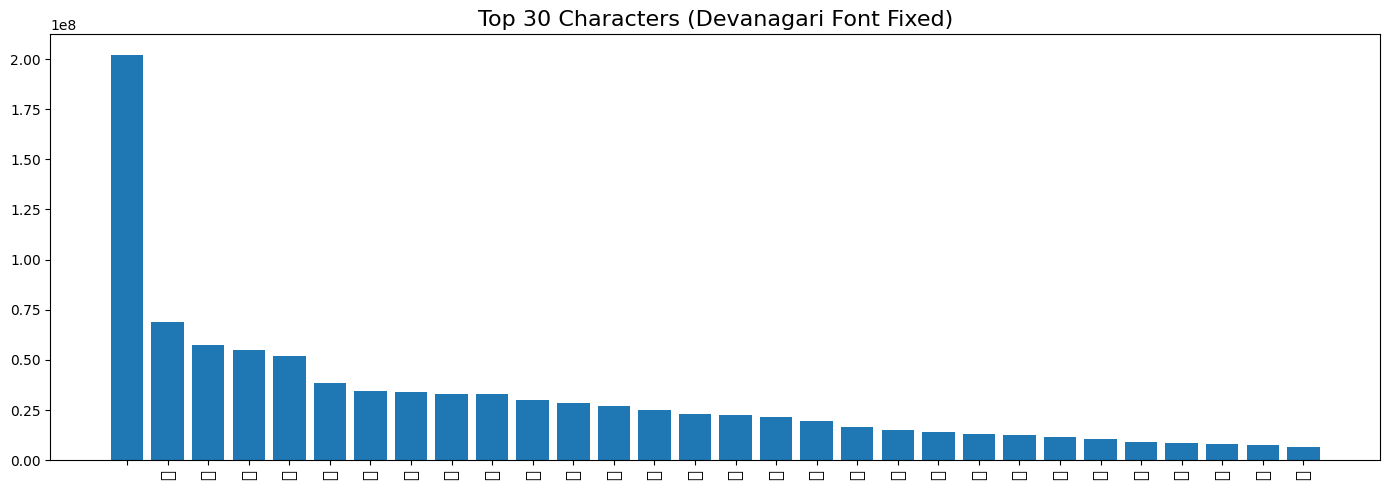

In [ ]:
# Example using your stats
top_chars = stats['top_chars'][:30]
chars, counts = zip(*top_chars)

plt.figure(figsize=(14,5))
plt.bar(range(len(chars)), counts)
plt.xticks(range(len(chars)), chars, rotation=90, fontsize=12)
plt.title("Top 30 Characters (Devanagari Font Fixed)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Run once in Colab
!pip install -q tokenizers datasets tqdm


In [ ]:
def detect_text_key(example):
    if isinstance(example, str):
        return None
    for k, v in example.items():
        if isinstance(v, str):
            return k
    return None

sample = train[0]
text_key = detect_text_key(sample)
print("Detected text key:", text_key)

def training_iterator(split, text_key=text_key):
    # yields str lines for tokenizer training
    for ex in split:
        if text_key is None:
            yield ex if isinstance(ex, str) else str(ex)
        else:
            yield ex.get(text_key, "")

Detected text key: text


**Tokenizer**

In [ ]:
##



from collections import Counter, defaultdict
import re

# Build initial vocab from list of words (with end-of-word marker)
def get_vocab(words):
    """
    words: iterable of strings (words / tokens)
    returns: dict mapping tuple(chars + </w>) -> frequency
    """
    vocab = Counter()
    for w in words:
        # split into characters; you can also split on unicode codepoints explicitly
        chars = list(w)
        token = tuple(chars + ['</w>'])
        vocab[token] += 1
    return vocab

def get_stats(vocab):
    """Return counts of adjacent symbol pairs (pair -> frequency)."""
    pairs = defaultdict(int)
    for token, freq in vocab.items():
        symbols = token
        for i in range(len(symbols)-1):
            pair = (symbols[i], symbols[i+1])
            pairs[pair] += freq
    return pairs

def merge_vocab(pair, vocab):
    """Merge all occurrences of the most frequent pair in the vocab."""
    merged_vocab = {}
    bigram = re.escape(' '.join(pair))
    # Efficient approach: iterate tokens and replace adjacent pair occurrences
    a, b = pair
    for token, freq in vocab.items():
        token_list = list(token)
        i = 0
        new_token = []
        while i < len(token_list):
            if i < len(token_list)-1 and token_list[i] == a and token_list[i+1] == b:
                # merge
                new_token.append(a + b)   # merged symbol
                i += 2
            else:
                new_token.append(token_list[i])
                i += 1
        merged_vocab[tuple(new_token)] = freq
    return merged_vocab

def bpe_learn(words, num_merges=100):
    """
    Learn BPE merges from the list of words.
    Returns final vocab (mapping of symbol sequences to frequencies) and merges list.
    """
    vocab = get_vocab(words)
    merges = []
    for i in range(num_merges):
        pairs = get_stats(vocab)
        if not pairs:
            break
        best = max(pairs, key=pairs.get)
        merges.append(best)
        vocab = merge_vocab(best, vocab)
        if (i+1) % 10 == 0:
            print(f"Completed {i+1} merges...")
    return vocab, merges

def bpe_tokenize_word(word, merges):
    """
    Tokenize a single word (string) using learned merges list (in order).
    """
    symbols = list(word) + ['</w>']
    for a, b in merges:
        i = 0
        merged_symbol = a + b
        while i < len(symbols) - 1:
            if symbols[i] == a and symbols[i+1] == b:
                symbols = symbols[:i] + [merged_symbol] + symbols[i+2:]
                # after merge we step back one position to allow overlapping merges
                i = max(i-1, 0)
            else:
                i += 1
    # remove end marker for presentation if needed
    if symbols and symbols[-1] == '</w>':
        symbols = symbols[:-1]
    return symbols


In [ ]:
# Example usage:
# Build a word list from a small slice of your dataset (for speed)
def get_word_list_from_dataset(split, text_key=None, max_lines=200000):
    words = []
    for i, ex in enumerate(split):
        if i >= max_lines:
            break
        text = ex if text_key is None else ex.get(text_key, "")
        # simple whitespace split; for Hindi you might split using regex to keep Devanagari tokens
        tokens = re.findall(r"[\u0900-\u097F]+|[A-Za-z0-9]+", text)
        for t in tokens:
            words.append(t)
    return words

# Build words
words = get_word_list_from_dataset(train, text_key, max_lines=20000)
print("Collected words:", len(words))

# Learn merges (small number to keep it fast)
vocab_after, merges = bpe_learn(words, num_merges=200)

print("Number of merges learned:", len(merges))
print("Top merges:", merges[:30])

# Tokenize a sample word
sample_word = words[0]
print("Sample word:", sample_word)
print("Tokenized:", bpe_tokenize_word(sample_word, merges[:1000]))


Collected words: 6934909
Completed 10 merges...
Completed 20 merges...
Completed 30 merges...
Completed 40 merges...
Completed 50 merges...
Completed 60 merges...
Completed 70 merges...
Completed 80 merges...
Completed 90 merges...
Completed 100 merges...
Completed 110 merges...
Completed 120 merges...
Completed 130 merges...
Completed 140 merges...
Completed 150 merges...
Completed 160 merges...
Completed 170 merges...
Completed 180 merges...
Completed 190 merges...
Completed 200 merges...
Number of merges learned: 200
Top merges: [('े', '</w>'), ('ा', '</w>'), ('ी', '</w>'), ('र', '</w>'), ('ं', '</w>'), ('क', 'े</w>'), ('ह', 'ै'), ('।', '</w>'), ('न', '</w>'), ('्', 'र'), ('े', 'ं</w>'), ('ो', '</w>'), ('न', 'े</w>'), ('म', 'ें</w>'), ('र', '्'), ('क', '</w>'), ('क', 'ी</w>'), ('त', '</w>'), ('स', 'े</w>'), ('क', 'ि'), ('स', '</w>'), ('ल', '</w>'), ('्', 'य'), ('ो', 'ं</w>'), ('स', '्'), ('ा', 'र'), ('क', 'ो</w>'), ('य', 'ा</w>'), ('म', '</w>'), ('क', 'ा</w>')]
Sample word: समाचार
T

In [ ]:
# Test your pure-Python BPE tokenizer on a single word
test_word = "समाचार"

tokens = bpe_tokenize_word(test_word, merges)
print("Word:", test_word)
print("BPE Tokens:", tokens)


Word: समाचार
BPE Tokens: ['स', 'मा', 'चा', 'र</w>']


In [ ]:
def bpe_tokenize_sentence(sentence, merges):
    # Split into words using your Hindi regex
    words = re.findall(r"[\u0900-\u097F]+|[A-Za-z0-9]+", sentence)

    output_tokens = []
    for w in words:
        sub_tokens = bpe_tokenize_word(w, merges)
        output_tokens.extend(sub_tokens)
    return output_tokens


In [ ]:
test_sentence = "यह एक नया वाक्य है।"

bpe_tokens = bpe_tokenize_sentence(test_sentence, merges)

print("Sentence:", test_sentence)
print("BPE Tokens:", bpe_tokens)


Sentence: यह एक नया वाक्य है।
BPE Tokens: ['यह</w>', 'एक</w>', 'न', 'या</w>', 'वा', 'क', '्य</w>', 'है।</w>']


#GPT


In [ ]:
# Ensure vocab_after exists from your BPE training:
# vocab_after, merges = bpe_learn(words, num_merges=200)

from collections import Counter

# Extract all atomic symbols from vocab_after
symbols = Counter()
for token_tuple, freq in vocab_after.items():
    for s in token_tuple:
        symbols[s] += freq

# Sort by frequency
sorted_symbols = [sym for sym, _ in symbols.most_common()]

# Build token → ID mapping
token2id = {tok: idx for idx, tok in enumerate(sorted_symbols)}
id2token = {idx: tok for tok, idx in token2id.items()}

print("token2id size:", len(token2id))


token2id size: 361


In [ ]:
import torch
import torch.nn as nn
import math


# Replace GPT vocab with YOUR tokenizer vocab
VOCAB_SIZE = len(token2id)

GPT_CONFIG = {
    "vocab_size": VOCAB_SIZE,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False
}

print("Your tokenizer vocab size:", GPT_CONFIG["vocab_size"])


Your tokenizer vocab size: 361


In [ ]:

# pick a vocab size: prefer token2id created from your BPE, otherwise fall back to GPT_CONFIG_124M
try:
    VOCAB_SIZE = len(token2id)
    print("Using tokenizer vocab size from token2id:", VOCAB_SIZE)
except NameError:
    VOCAB_SIZE = GPT_CONFIG["vocab_size"]
    print("token2id not found — using GPT_CONFIG_124M vocab size:", VOCAB_SIZE)

# Continue normally
EMB_DIM = GPT_CONFIG["emb_dim"]
CTX_LEN = GPT_CONFIG["context_length"]
N_HEADS = GPT_CONFIG["n_heads"]
N_LAYERS = GPT_CONFIG["n_layers"]
DROP_RATE = GPT_CONFIG["drop_rate"]
QKV_BIAS = GPT_CONFIG["qkv_bias"]


Using tokenizer vocab size from token2id: 361


In [ ]:
import torch
import torch.nn as nn

class TokenPosEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_dim, context_length):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        # Learned positional embeddings
        self.pos_emb = nn.Embedding(context_length, emb_dim)
        self.emb_dropout = nn.Dropout(DROP_RATE)

    def forward(self, input_ids):
        """
        input_ids: (B, T)
        returns: (B, T, C)
        """
        B, T = input_ids.shape
        assert T <= self.pos_emb.num_embeddings, "Sequence length exceeds context length"
        tok = self.token_emb(input_ids)                     # (B, T, C)
        positions = torch.arange(0, T, device=input_ids.device).unsqueeze(0)  # (1, T)
        pos = self.pos_emb(positions)                       # (1, T, C)
        x = tok + pos
        return self.emb_dropout(x)

# Quick test
embedding = TokenPosEmbedding(VOCAB_SIZE, EMB_DIM, CTX_LEN)
input_ids = torch.randint(0, VOCAB_SIZE, (2, 10))
out = embedding(input_ids)
print("TokenPosEmbedding output shape:", out.shape)   # expect (2, 10, EMB_DIM)
assert out.shape == (2, 10, EMB_DIM)


TokenPosEmbedding output shape: torch.Size([2, 10, 512])


In [ ]:
import torch.nn.functional as F

class CausalSelfAttention(nn.Module):
    def __init__(self, emb_dim, n_heads, drop_rate=0.1, qkv_bias=False):
        super().__init__()
        assert emb_dim % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=qkv_bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim)
        self.attn_drop = nn.Dropout(drop_rate)
        self.proj_drop = nn.Dropout(drop_rate)

        # Causal mask will be created on-the-fly if needed

    def forward(self, x, attn_mask=None):
        # x: (B, T, C)
        B, T, C = x.size()
        qkv = self.qkv(x)                          # (B, T, 3C)
        qkv = qkv.view(B, T, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]          # each (B, heads, T, head_dim)

        # compute attention
        att = torch.matmul(q, k.transpose(-2, -1)) * self.scale   # (B, heads, T, T)

        # causal mask: allow only j <= i (triangular)
        causal_mask = torch.tril(torch.ones((T, T), device=x.device)).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
        att = att.masked_fill(causal_mask == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = torch.matmul(att, v)                   # (B, heads, T, head_dim)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.proj_drop(self.out_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, emb_dim, ff_mult=4, drop_rate=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * ff_mult),
            nn.GELU(),
            nn.Linear(emb_dim * ff_mult, emb_dim),
            nn.Dropout(drop_rate)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, n_heads, ff_mult=4, drop_rate=0.1, qkv_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.attn = CausalSelfAttention(emb_dim, n_heads, drop_rate, qkv_bias)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.ff = FeedForward(emb_dim, ff_mult, drop_rate)

    def forward(self, x):
        # Pre-LN style
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tokpos = TokenPosEmbedding(config["vocab_size"], config["emb_dim"], config["context_length"])
        self.drop = nn.Dropout(config["drop_rate"])
        self.blocks = nn.ModuleList([TransformerBlock(config["emb_dim"], config["n_heads"], ff_mult=4, drop_rate=config["drop_rate"], qkv_bias=config["qkv_bias"]) for _ in range(config["n_layers"])])
        self.ln_f = nn.LayerNorm(config["emb_dim"])
        # language modeling head tied to token embeddings (weight tying)
        self.head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)
        # tie weights
        self.head.weight = self.tokpos.token_emb.weight

    def forward(self, input_ids):
        """
        input_ids: (B, T) LongTensor
        returns: logits (B, T, V)
        """
        x = self.tokpos(input_ids)   # (B, T, C)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

# Build model using current config
model_config = {
    "vocab_size": VOCAB_SIZE,
    "context_length": CTX_LEN,
    "emb_dim": EMB_DIM,
    "n_heads": N_HEADS,
    "n_layers": N_LAYERS,
    "drop_rate": DROP_RATE,
    "qkv_bias": QKV_BIAS
}

model = TinyGPT(model_config)
print("Model created. Parameter count:", sum(p.numel() for p in model.parameters()))


Model created. Parameter count: 13051392


In [ ]:
# Create random input batch (B, T)
BATCH = 2
SEQLEN = 512

input_ids = torch.randint(0, VOCAB_SIZE, (BATCH, SEQLEN))
with torch.no_grad():
    logits = model(input_ids)
print("Logits shape:", logits.shape)   # expect (B, T, VOCAB_SIZE)

# Compute a dummy loss (cross-entropy) on shifted targets for language modeling
# Shift inputs by one for next-token prediction
targets = torch.randint(0, VOCAB_SIZE, (BATCH, SEQLEN))
loss_f = nn.CrossEntropyLoss()
# Flatten logits and targets for loss: (B*T, V), (B*T)
loss = loss_f(logits.view(-1, VOCAB_SIZE), targets.view(-1))
print("Dummy loss:", loss.item())


Logits shape: torch.Size([2, 512, 361])
Dummy loss: 330.2403564453125


In [ ]:
# --- Encode / Decode using your BPE tokenizer and token2id ---

def encode_sentence(sentence: str):
    """
    Use your BPE tokenizer + token2id to convert a sentence to a list of token IDs.
    """
    tokens = bpe_tokenize_sentence(sentence, merges)
    ids = [token2id[tok] for tok in tokens if tok in token2id]
    return ids

def decode_ids(ids):
    """
    Naive decode from IDs back to text using id2token.
    This is approximate (BPE merges destroyed exact spacing),
    but good enough to demo model outputs.
    """
    tokens = [id2token.get(int(i), "") for i in ids]
    # simple join; you can experiment with adding spaces
    return "".join(tokens)


In [ ]:
from itertools import islice
import torch

def build_token_id_corpus(split, text_key=text_key, max_samples=50_000):
    """
    Turn a split (e.g., train) into one long tensor of token IDs.
    We only use up to max_samples examples to keep it lightweight.
    """
    all_ids = []
    for i, text in enumerate(training_iterator(split, text_key=text_key)):
        if i >= max_samples:
            break
        if not isinstance(text, str):
            text = str(text)
        encoded = encode_sentence(text)
        if len(encoded) == 0:
            continue
        # Optionally, you can append a special EOS token if you have one;
        # here we just concatenate the sequences.
        all_ids.extend(encoded)
    return torch.tensor(all_ids, dtype=torch.long)

print("Building token ID corpus for train split...")
train_ids = build_token_id_corpus(train, text_key=text_key, max_samples=30_000)
print("Train token ids:", train_ids.shape)

# Build a small validation set.
# If dataset has 'test' split, use it; otherwise, slice from the end of train_ids.
if "test" in ds:
    print("Building token ID corpus for test split...")
    val_ids = build_token_id_corpus(ds["test"], text_key=text_key, max_samples=5_000)
else:
    # last 10% of train_ids as validation
    split_idx = int(0.9 * len(train_ids))
    val_ids = train_ids[split_idx:].clone()
    train_ids = train_ids[:split_idx].clone()

print("Final train_ids:", train_ids.shape)
print("Final val_ids:  ", val_ids.shape)


Building token ID corpus for train split...
Train token ids: torch.Size([27632475])
Final train_ids: torch.Size([24869227])
Final val_ids:   torch.Size([2763248])


In [ ]:
# --- Batch generator for next-token prediction ---

BLOCK_SIZE = min(128, CTX_LEN)  # keep <= CTX_LEN
BATCH_SIZE = 512

assert BLOCK_SIZE <= CTX_LEN, "BLOCK_SIZE must be <= model context length"

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def get_batch(data_ids, batch_size=BATCH_SIZE, block_size=BLOCK_SIZE):
    """
    Randomly sample a batch of subsequences from a 1D tensor of token IDs.
    Returns x (input), y (targets) of shape (B, T).
    """
    # ensure we have enough tokens
    max_start = len(data_ids) - block_size - 1
    ix = torch.randint(0, max_start, (batch_size,))
    x = torch.stack([data_ids[i:i+block_size] for i in ix])
    y = torch.stack([data_ids[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [ ]:
import torch.nn.functional as F

# --- Optimizer ---
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def estimate_loss(eval_iters=20):
    """
    Compute average loss on train & val for logging.
    """
    model.eval()
    out = {}
    for split_name, data_ids in [("train", train_ids), ("val", val_ids)]:
        losses = []
        for _ in range(eval_iters):
            xb, yb = get_batch(data_ids)
            with torch.no_grad():
                logits = model(xb)
                loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE),
                                       yb.view(-1))
            losses.append(loss.item())
        out[split_name] = sum(losses) / len(losses)
    model.train()
    return out

# --- Main training loop ---
max_iters = 500   # you can increase if you have time/GPU
log_interval = 50

for step in range(1, max_iters + 1):
    xb, yb = get_batch(train_ids)
    logits = model(xb)
    loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE),
                           yb.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % log_interval == 0 or step == 1:
        losses = estimate_loss()
        print(f"Step {step:5d} | train loss: {losses['train']:.4f} | val loss: {losses['val']:.4f}")


Step     1 | train loss: 317.3938 | val loss: 317.4657


KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=50, temperature=1.0, top_k=None):
    """
    Autoregressively generate tokens from the model, starting from 'prompt'.
    """
    model.eval()
    # Encode prompt to ids
    prompt_ids = encode_sentence(prompt)
    if len(prompt_ids) == 0:
        raise ValueError("Prompt produced no tokens. Try a different prompt.")
    x = torch.tensor([prompt_ids], dtype=torch.long, device=device)

    for _ in range(max_new_tokens):
        # crop context if needed
        if x.size(1) > CTX_LEN:
            x_cond = x[:, -CTX_LEN:]
        else:
            x_cond = x

        logits = model(x_cond)           # (B, T, V)
        logits = logits[:, -1, :]        # (B, V) - last time step
        if temperature != 1.0:
            logits = logits / temperature

        probs = F.softmax(logits, dim=-1)

        if top_k is not None:
            # keep only top_k probabilities
            v, ix = torch.topk(probs, top_k)
            probs = torch.zeros_like(probs).scatter_(1, ix, v)
            probs = probs / probs.sum(dim=-1, keepdim=True)

        next_id = torch.multinomial(probs, num_samples=1)  # (B, 1)
        x = torch.cat([x, next_id], dim=1)

    out_ids = x[0].tolist()
    return decode_ids(out_ids)

# Example generation
prompt = "भारत में शिक्षा"
print("PROMPT:", prompt)
print("GENERATED:\n", generate_text(model, prompt, max_new_tokens=60, temperature=0.9, top_k=20))


In [ ]:
def decode_ids(ids):
    """
    Convert token IDs back to clean Hindi text without </w>.
    """
    tokens = [id2token[i] for i in ids]

    # Remove end-of-word markers
    cleaned = [t.replace("</w>", "") for t in tokens]

    # Devanagari script does NOT use spaces between subword pieces,
    # only between whole words. So we join by "" and then fix spacing.
    text = "".join(cleaned)

    # Put space between Hindi words using your rule:
    # Insert space before tokens that originally ended with </w>.
    # But since we stripped </w>, we need another trick:
    # Your BPE tokens for Hindi alphabets usually start with a consonant/vowel.
    # A simple heuristic: Add space before capital Latin tokens or digits.

    # Simpler and safer: split using original tokens before cleaning
    out_words = []
    current_word = ""

    for tok in tokens:
        if tok.endswith("</w>"):
            tok_clean = tok.replace("</w>", "")
            current_word += tok_clean
            out_words.append(current_word)
            current_word = ""
        else:
            current_word += tok.replace("</w>", "")

    if current_word:
        out_words.append(current_word)

    return " ".join(out_words)

In [ ]:
@torch.no_grad()
def generate_text(model, prompt, max_words=100, temperature=1.0, top_k=None):
    model.eval()

    # Encode
    prompt_ids = encode_sentence(prompt)
    x = torch.tensor([prompt_ids], dtype=torch.long, device=device)

    generated_ids = prompt_ids.copy()

    # We'll count words using decoded text
    while True:
        if len(generated_ids) > CTX_LEN:
            x_cond = x[:, -CTX_LEN:]
        else:
            x_cond = x

        logits = model(x_cond)
        logits = logits[:, -1, :]
        logits = logits / temperature
        probs = F.softmax(logits, dim=-1)

        if top_k:
            top_vals, top_idx = torch.topk(probs, top_k)
            probs = torch.zeros_like(probs).scatter_(1, top_idx, top_vals)
            probs = probs / probs.sum(dim=-1, keepdim=True)

        next_id = torch.multinomial(probs, num_samples=1).item()
        generated_ids.append(next_id)

        # update tensor
        x = torch.tensor([generated_ids], dtype=torch.long, device=device)

        # Check word count
        decoded = decode_ids(generated_ids)
        if len(decoded.split()) >= max_words:
            break

    return decoded